This notebook contains the code for the Machine Learning project phase of the Predicting Water Pump Status project.

5 algorithms for supervised, multi-classification problems were chosen: KNN, Logistic Regression, RandomForest, AdaBoost and XGBoost.  

Data was prepared using one hot encoding, split into training and test sets and scaled.

The approach to the model creation and prediction process for using these algorithms followed four steps:
1. The 5 algorithms were run on the low-variance dataset.  Feature importances were evaluated for model performance improvement.

2. The 5 algorithms were run on the high-variance dataset.  Feature importances were evaluated for model performance improvement. 

3. Using the dataset that produced the best results, the 5 models were optimized with cross-validation and hyperparameter tuning.

4. Using the best dataset and tuned models, principal component analysis was performed for performance improvement.


In [1]:
import os
import csv 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import savefig
from datetime import datetime
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

#functions written for the machine learning phase
from ml_support_functions import create_model

### Main Calling Section

In [2]:
#initialize run parameters
results_file = 'C2MLResults_3.csv'
df_all_results = pd.DataFrame(columns=['algorithm', 'data note', 'Func F1', 'Non_Func F1', 'Needs_Maint F1', 
                                       'train_acc', 'test_acc', 'run time','hyper_params'])

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
              

In [3]:
#read the dataset prepared for the machine learning phase
dataset_type = 'low_var, ohe'
df_orig = pd.read_csv('low_var.csv') #, nrows=5000) 

df_ml = df_orig.copy()
df_ml.drop(df_ml.columns[0], axis=1, inplace=True)

print('Dataframe shape: ', df_ml.shape)


Dataframe shape:  (59399, 12)


### Perform one hot encoding of categorical values

Convert all features of type object to one hot encoded features. Use the 'drop first' option to avoid creating multicolinearity.

In [4]:
# change the target feature first so it is not vectorized
label_dict_status_group = {'functional':0,
                   'non functional': 1,
                   'functional needs repair': 2}
df_ml['status_group'] = df_ml['status_group'].replace(label_dict_status_group).astype(int)

    
# Step 1 - generate numeric values for all categorical columns
# create a list of the columns of type object
ml_datatypes = pd.DataFrame(df_ml.dtypes, columns=['datatype']).reset_index()
ml_datatypes.columns=['feature', 'datatype']
object_cols = ml_datatypes[ml_datatypes['datatype']=='object']
cols = object_cols['feature'].values

# factorize each object column
for col in cols:
    df_ml[col] = pd.factorize(df_ml[col])[0].astype('object')
    
# Step 2 - create encoded vectors
df_ml_enc = pd.get_dummies(df_ml, drop_first=True)
df_ml_enc.shape


(59399, 53)

One hot encoding changed the number of features from 12 to 53

### Split the data into train and test sets

In [5]:
#Create numpy arrays for the features and the response variable
y = df_ml_enc['status_group'].to_numpy()

df_ml_data = df_ml_enc.drop('status_group', axis=1)
X = df_ml_data.values
colnames = df_ml_data.columns

#Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


### Scale the data 

In [6]:
feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

## Step 1: Run ML models on Low Variance Dataset

## 1.1 K Nearest Neighbors - Low Variance

This alogrithm predicts the class of a new data point by majority vote of the "K nearest neighbors".

#### KNN with default parameters and rule-of-thumb for K

K determines how many neighbors are evaluated. With K at the extreme value of 1, we create a rough decision boundary and "islands" of data points, overfitting the model. We would get a new decision boundary for each new dataset, making the variance (how much the algoirthm changes given new data) very high.  The bias is very low, because on average the classification performance is accurate.

To reduce the roughness of the decision boundary, we increase K and the algorithm uses a majority vote for classification. This reduces the variance, but increases the bias.  If K is too large, we may make the boundary too smooth and make too many mistakes.

The rule-of-thumb for K is to use the square root of the number of features.

In [7]:
k = int(np.sqrt(len(X_train)))
knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                           metric='minkowski', metric_params=None, n_jobs=None)

knn_model, df_results = create_model('KNeighborsClassifier', knn, dataset_type, X_train, X_test, y_train, y_test, tuning_model='None')
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5837  624   33]
 [1955 2567   26]
 [ 651  123   64]]
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.90      0.78      6494
           1       0.77      0.56      0.65      4548
           2       0.52      0.08      0.13       838

    accuracy                           0.71     11880
   macro avg       0.66      0.51      0.52     11880
weighted avg       0.71      0.71      0.69     11880

Run time:  0:00:51.587570


The model produced a good F1 score for the functional class (0) but scores were not as good for the 'non functional' and 'functional needs maintenance classes'.  This gradient makes sense as it follows the prevalence gradient of those classes in the data. Performing cross-validation could help improve these results.

## 1.2. Logistic Regression - Low Variance

Logistic regression is the linear model for classification, which models the probabilities of classification outcomes with a logistic function. The error term to minimize is the mean squared error.  

In [8]:
log_reg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=4000)

log_reg_model, df_results = create_model('LogisticRegression', log_reg, dataset_type, X_train, X_test, y_train, y_test)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5744  735   15]
 [1882 2656   10]
 [ 678  135   25]]
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.88      0.78      6494
           1       0.75      0.58      0.66      4548
           2       0.50      0.03      0.06       838

    accuracy                           0.71     11880
   macro avg       0.65      0.50      0.50     11880
weighted avg       0.70      0.71      0.68     11880

Run time:  0:00:01.959735


This model produced the same F1 score for the 'functional' class, a slightly better score for the 'non functional' class, and a worse score for the 'functional needs repair' class. To improve these results, we will try examining feature importances and re-running the model after dropping features with low coefficients.

In [9]:
feature_importances = pd.DataFrame({'feature': colnames, 'importance': log_reg_model.coef_[0]})
feature_importances[abs(feature_importances['importance'])<0.05]

,feature,importance
0,construction_year,-0.045578
1,gps_height,-0.035450
11,extraction_type_class_1,0.004916
14,extraction_type_class_4,-0.030253
17,management_group_3,0.000861
20,payment_type_3,-0.008495
22,quantity_2,-0.024171
24,quantity_4,-0.041823
25,region_1,-0.014981
28,region_4,0.013291


In [10]:
# running the model without low-coefficient data 
bool_mask = abs(feature_importances['importance'])<0.05
Xtrain_reduced = X_train[:,bool_mask]
Xtest_reduced = X_test[:,bool_mask]

log_reg_model, df_results = create_model('LogisticRegression FR', log_reg, dataset_type, Xtrain_reduced, Xtest_reduced, y_train, y_test)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5632  862    0]
 [3390 1158    0]
 [ 765   73    0]]
Classification report: 
               precision    recall  f1-score   support

           0       0.58      0.87      0.69      6494
           1       0.55      0.25      0.35      4548
           2       0.00      0.00      0.00       838

    accuracy                           0.57     11880
   macro avg       0.38      0.37      0.35     11880
weighted avg       0.53      0.57      0.51     11880

Run time:  0:00:00.312436


/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

The results were not improved by reducing features, and the model was not able to produce predictions for the 'functional needs maintenance' class, so the original set of features will be used in future iterations.

## 1.3. Random Forest - Low Variance
This algorithm uses an ensemble of decision trees. The individual trees are formed by branching on each of the features in the dataset. Each leaf is a possible outcome for the feature.  Creating an ensemble avoids the problem of overfitting that commonly occurs in individual trees.

In [11]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model, df_results = create_model('Random Forest', rfc, dataset_type, X_train, X_test, y_train, y_test, tuning_model='None')
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5594  676  224]
 [1106 3353   89]
 [ 497  128  213]]
Classification report: 
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      6494
           1       0.81      0.74      0.77      4548
           2       0.40      0.25      0.31       838

    accuracy                           0.77     11880
   macro avg       0.66      0.62      0.63     11880
weighted avg       0.76      0.77      0.76     11880

Run time:  0:00:07.526472


The RandomForest classifier out-performed KNN and LogisticRegression on all classes, and showed a big improvement. In an attempt to improve these results further, we'll try feature reduction.

In [12]:
feature_importances = pd.DataFrame({'feature': colnames, 'importance': rfc_model.feature_importances_})
feature_importances[abs(feature_importances['importance'])<0.005]

,feature,importance
25,region_1,0.003108
26,region_2,0.002800
27,region_3,0.003904
28,region_4,0.004091
30,region_6,0.002482
31,region_7,0.004057
32,region_8,0.003619
34,region_10,0.003757
35,region_11,0.003659
37,region_13,0.002709


In [13]:
# running the model without low-coefficient data 
bool_mask = abs(feature_importances['importance'])<0.005
Xtrain_reduced = X_train[:,bool_mask]
Xtest_reduced = X_test[:,bool_mask]

rfc_model, df_results = create_model('Random Forest FR', rfc, dataset_type, Xtrain_reduced, Xtest_reduced, y_train, y_test)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5776  718    0]
 [3551  997    0]
 [ 759   79    0]]
Classification report: 
               precision    recall  f1-score   support

           0       0.57      0.89      0.70      6494
           1       0.56      0.22      0.31      4548
           2       0.00      0.00      0.00       838

    accuracy                           0.57     11880
   macro avg       0.38      0.37      0.34     11880
weighted avg       0.53      0.57      0.50     11880

Run time:  0:00:01.636282


/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

As with Logistic Regression, the results were not improved by reducing features, and the model was not able to produce predictions for the 'functional needs maintenance' class, so the original set of features will be used in future iterations.

## 1.4. AdaBoost - Low Variance
The Adaptive Boosting algorithm uses repeated training of weak learners on weighted training data, where incorrect predictions are given more influence, so subsequent learners are directed to focus on examples missed by previous iterations.

In [14]:
abc = AdaBoostClassifier(n_estimators=50, base_estimator=None, learning_rate=1, random_state=42)

abc_model, df_results = create_model('AdaBoost default', abc, dataset_type, X_train, X_test, y_train, y_test, tuning_model='None')
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5817  663   14]
 [1860 2666   22]
 [ 679  137   22]]
Classification report: 
               precision    recall  f1-score   support

           0       0.70      0.90      0.78      6494
           1       0.77      0.59      0.67      4548
           2       0.38      0.03      0.05       838

    accuracy                           0.72     11880
   macro avg       0.61      0.50      0.50     11880
weighted avg       0.70      0.72      0.69     11880

Run time:  0:00:03.885111


These results were not as good as the Random Forest classifier. To improve them, we'll try feature reduction.

In [15]:
feature_importances = pd.DataFrame({'feature': colnames, 'importance': abc_model.feature_importances_})
feature_importances[abs(feature_importances['importance'])==0]

,feature,importance
6,basin_4,0.0
8,basin_6,0.0
9,basin_7,0.0
15,management_group_1,0.0
22,quantity_2,0.0
25,region_1,0.0
26,region_2,0.0
27,region_3,0.0
28,region_4,0.0
30,region_6,0.0


In [16]:
#running the model without low-coefficient data 
bool_mask = abs(feature_importances['importance'])==0
Xtrain_reduced = X_train[:,bool_mask]
Xtest_reduced = X_test[:,bool_mask]

abc_model, df_results = create_model('AdaBoost default FR', abc, dataset_type, Xtrain_reduced, Xtest_reduced, y_train, y_test)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5798  696    0]
 [3721  827    0]
 [ 774   64    0]]
Classification report: 
               precision    recall  f1-score   support

           0       0.56      0.89      0.69      6494
           1       0.52      0.18      0.27      4548
           2       0.00      0.00      0.00       838

    accuracy                           0.56     11880
   macro avg       0.36      0.36      0.32     11880
weighted avg       0.51      0.56      0.48     11880

Run time:  0:00:01.459648


/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

Once again, the results were not improved by reducing features and the model could not produce predictions for the smallest class. The original set of features will be used going forward.

## 1.5. XGBoost - Low Variance
The Extreme Gradient Boosting algorithm is an implementation of gradient boosted decision trees.  Like Adaptive Boosting, it trains many models sequentially. Each new model gradually minimizes a loss function of the whole system using the Gradient Descent method, an iterative optimization algorithm for finding the minimum of a function. The goal is to create new base learners that are maximally correlated with a negative gradient of the loss function associated with the whole ensemble.  

In [17]:
#max_delta_step = 1 helps with tuning for imbalanced dataset where we care about the probability, not AUC 
xgb_def = xgb.XGBClassifier(max_delta_step = 1, seed=42)

model, df_results = create_model('XGBoost default', xgb_def, dataset_type, X_train, X_test, y_train, y_test, tuning_model='None')
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[6071  402   21]
 [1880 2645   23]
 [ 683   98   57]]
Classification report: 
               precision    recall  f1-score   support

           0       0.70      0.93      0.80      6494
           1       0.84      0.58      0.69      4548
           2       0.56      0.07      0.12       838

    accuracy                           0.74     11880
   macro avg       0.70      0.53      0.54     11880
weighted avg       0.75      0.74      0.71     11880

Run time:  0:00:42.314048


Interestingly, XGBoost did not out-perform the Random Forest classifier. 

## Results so far: all 5 models on the low-variance dataset

In [18]:
df_all_results

,algorithm,data note,Func F1,Non_Func F1,Needs_Maint F1,train_acc,test_acc,run time,hyper_params
0,KNeighborsClassifier,"low_var, ohe",0.781549,0.653015,0.133195,0.710411,0.712795,00:00:51.587570,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
0,LogisticRegression,"low_var, ohe",0.776321,0.657914,0.056306,0.709948,0.709175,00:00:01.959735,"{'C': 1.0, 'class_weight': None, 'dual': False..."
0,LogisticRegression FR,"low_var, ohe",0.691849,0.348743,0.000000,0.559944,0.571549,00:00:00.312436,"{'C': 1.0, 'class_weight': None, 'dual': False..."
0,Random Forest,"low_var, ohe",0.817179,0.770362,0.312317,0.921884,0.771044,00:00:07.526472,"{'bootstrap': True, 'class_weight': None, 'cri..."
0,Random Forest FR,"low_var, ohe",0.696743,0.314412,0.000000,0.572171,0.570118,00:00:01.636282,"{'bootstrap': True, 'class_weight': None, 'cri..."
0,AdaBoost default,"low_var, ohe",0.783434,0.665336,0.049107,0.715272,0.715909,00:00:03.885111,"{'algorithm': 'SAMME.R', 'base_estimator': Non..."
0,AdaBoost default FR,"low_var, ohe",0.690773,0.269601,0.000000,0.558029,0.557660,00:00:01.459648,"{'algorithm': 'SAMME.R', 'base_estimator': Non..."
0,XGBoost default,"low_var, ohe",0.802618,0.687638,0.121406,0.738126,0.738468,00:00:42.314048,"{'base_score': 0.5, 'booster': 'gbtree', 'cols..."


The results so far show that the best-performing algorithm is Random Forest.

## Step 2. Run the models on the high-variance dataset

In [19]:
#read the dataset prepared for the machine learning phase
dataset_type = 'high_var, ohe'
df_orig = pd.read_csv('high_var.csv') 

df_ml = df_orig.copy()
df_ml.drop(df_ml.columns[0], axis=1, inplace=True)

print('Dataframe shape: ', df_ml.shape)

Dataframe shape:  (59399, 14)


In [20]:
# change the target feature first so it is not vectorized
label_dict_status_group = {'functional':0,
                   'non functional': 1,
                   'functional needs repair': 2}
df_ml['status_group'] = df_ml['status_group'].replace(label_dict_status_group).astype(int)


### Preprocess the data by one hot encoding, splitting into test and training sets and scaling.

In [21]:
# Step 1 - generate numeric values for all categorical columns
# create a list of the columns of type object
ml_datatypes = pd.DataFrame(df_ml.dtypes, columns=['datatype']).reset_index()
ml_datatypes.columns=['feature', 'datatype']
object_cols = ml_datatypes[ml_datatypes['datatype']=='object']
cols = object_cols['feature'].values

In [22]:
# factorize each object column
for col in cols:
    df_ml[col] = pd.factorize(df_ml[col])[0].astype('object')
    

In [23]:
# Step 2 - create encoded vectors
df_ml_enc = pd.get_dummies(df_ml, drop_first=True)
df_ml_enc.shape

(59399, 56)

In [24]:

#Create numpy arrays for the features and the response variable
y = df_ml_enc['status_group'].to_numpy()

df_ml_data = df_ml_enc.drop('status_group', axis=1)
X = df_ml_data.values
colnames = df_ml_data.columns

#Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#Scale
feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

## 2.1. KNN - High Variance

In [25]:
k = int(np.sqrt(len(X_train)))
knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                           metric='minkowski', metric_params=None, n_jobs=None)

knn_model, df_results = create_model('KNeighborsClassifier', knn, dataset_type, X_train, X_test, y_train, y_test, tuning_model='None')
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5885  572   37]
 [2067 2456   25]
 [ 637  124   77]]
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.91      0.78      6494
           1       0.78      0.54      0.64      4548
           2       0.55      0.09      0.16       838

    accuracy                           0.71     11880
   macro avg       0.67      0.51      0.53     11880
weighted avg       0.71      0.71      0.68     11880

Run time:  0:01:00.895336


The results of the KNN model created with the high-variance dataset produced mixed results compared to the low-variance dataset.  The 'functional' F1 score stayed the same, the 'non functional' score decreased slightly, and the 'functional needs maintenance' category improved.

## 2.2.  Logistic Regression - High Variance

In [26]:
log_reg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=4000)

log_reg_model, df_results = create_model('LogisticRegression', log_reg, dataset_type, X_train, X_test, y_train, y_test)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5817  655   22]
 [1865 2661   22]
 [ 694  122   22]]
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.90      0.78      6494
           1       0.77      0.59      0.67      4548
           2       0.33      0.03      0.05       838

    accuracy                           0.72     11880
   macro avg       0.60      0.50      0.50     11880
weighted avg       0.70      0.72      0.69     11880

Run time:  0:00:01.521926


The results of the Logistic Regression model created with the high-variance dataset produced better results across all categories compared to the low-variance dataset.  It did not however outperform the Random Forest model created with the low-variance dataset.  We'll see if feature reduction improves the outcome.

In [27]:
feature_importances = pd.DataFrame({'feature': colnames, 'importance': log_reg_model.coef_[0]})
feature_importances[abs(feature_importances['importance'])<0.05]

,feature,importance
3,longitude,0.022257
5,region_code,-0.038318
6,basin_1,-0.044029
18,extraction_type_group_5,-0.011701
19,extraction_type_group_6,0.002611
20,extraction_type_group_7,-0.006745
22,extraction_type_group_9,0.045267
23,extraction_type_group_10,0.021762
24,extraction_type_group_11,0.031094
25,extraction_type_group_12,-0.016162


In [28]:
# running the model without low-coefficient data 
bool_mask = abs(feature_importances['importance'])<0.05
Xtrain_reduced = X_train[:,bool_mask]
Xtest_reduced = X_test[:,bool_mask]

log_reg_model, df_results = create_model('LogisticRegression FR', log_reg, dataset_type, Xtrain_reduced, Xtest_reduced, y_train, y_test)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5950  536    8]
 [2859 1678   11]
 [ 744   91    3]]
Classification report: 
               precision    recall  f1-score   support

           0       0.62      0.92      0.74      6494
           1       0.73      0.37      0.49      4548
           2       0.14      0.00      0.01       838

    accuracy                           0.64     11880
   macro avg       0.50      0.43      0.41     11880
weighted avg       0.63      0.64      0.59     11880

Run time:  0:00:00.434861


While the model was able to create predictions for all classes (unlike with the low-variance dataset), reducing the features in the high-variance dataset lead to worse results in the Logistic Regression model for all F1 scores.  

## 2.3.  Random Forest - High Variance

In [29]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model, df_results = create_model('Random Forest', rfc, dataset_type, X_train, X_test, y_train, y_test, tuning_model='None')
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5650  635  209]
 [ 934 3516   98]
 [ 433  131  274]]
Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      6494
           1       0.82      0.77      0.80      4548
           2       0.47      0.33      0.39       838

    accuracy                           0.79     11880
   macro avg       0.70      0.66      0.67     11880
weighted avg       0.79      0.79      0.79     11880

Run time:  0:00:09.236124


This Random Forest model outperformed the Random Forest model created using the low-variance dataset, making this the new top-performing model. Once again we will attempt to improve on these results with feature reduction.

In [30]:
feature_importances = pd.DataFrame({'feature': colnames, 'importance': rfc_model.feature_importances_})
feature_importances[abs(feature_importances['importance'])<0.005]

,feature,importance
6,basin_1,0.003567
7,basin_2,0.003433
8,basin_3,0.003770
10,basin_5,0.003663
11,basin_6,0.003552
12,basin_7,0.004117
13,basin_8,0.003812
15,extraction_type_group_2,0.004073
17,extraction_type_group_4,0.003005
19,extraction_type_group_6,0.004831


In [31]:
# running the model without low-coefficient data 
bool_mask = abs(feature_importances['importance'])<0.005
Xtrain_reduced = X_train[:,bool_mask]
Xtest_reduced = X_test[:,bool_mask]

rfc_model, df_results = create_model('Random Forest FR', rfc, dataset_type, Xtrain_reduced, Xtest_reduced, y_train, y_test)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5764  725    5]
 [3290 1256    2]
 [ 708  130    0]]
Classification report: 
               precision    recall  f1-score   support

           0       0.59      0.89      0.71      6494
           1       0.59      0.28      0.38      4548
           2       0.00      0.00      0.00       838

    accuracy                           0.59     11880
   macro avg       0.40      0.39      0.36     11880
weighted avg       0.55      0.59      0.53     11880

Run time:  0:00:03.373237


While this model was also able to create predictions for all classes (unlike with the low-variance dataset), reducing the features in the high-variance dataset lead to worse results in the Random Forest model for all F1 scores.  

## 2.4.  AdaBoost - High Variance

In [32]:
abc = AdaBoostClassifier(n_estimators=50, base_estimator=None, learning_rate=1, random_state=42)

abc_model, df_results = create_model('AdaBoost default', abc, dataset_type, X_train, X_test, y_train, y_test, tuning_model='None')
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5876  581   37]
 [1860 2663   25]
 [ 654  138   46]]
Classification report: 
               precision    recall  f1-score   support

           0       0.70      0.90      0.79      6494
           1       0.79      0.59      0.67      4548
           2       0.43      0.05      0.10       838

    accuracy                           0.72     11880
   macro avg       0.64      0.52      0.52     11880
weighted avg       0.71      0.72      0.70     11880

Run time:  0:00:05.297490


While this AdaBoost model produced better results than with the low-variance dataset, it did not out-perform the best model so far. We'll try feature reduction, just in case.

In [33]:
feature_importances = pd.DataFrame({'feature': colnames, 'importance': abc_model.feature_importances_})
feature_importances[abs(feature_importances['importance'])==0]

,feature,importance
4,permit,0.0
6,basin_1,0.0
8,basin_3,0.0
10,basin_5,0.0
11,basin_6,0.0
12,basin_7,0.0
14,extraction_type_group_1,0.0
15,extraction_type_group_2,0.0
17,extraction_type_group_4,0.0
19,extraction_type_group_6,0.0


In [34]:
#running the model without low-coefficient data 
bool_mask = abs(feature_importances['importance'])==0
Xtrain_reduced = X_train[:,bool_mask]
Xtest_reduced = X_test[:,bool_mask]

abc_model, df_results = create_model('AdaBoost default FR', abc, dataset_type, Xtrain_reduced, Xtest_reduced, y_train, y_test)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[6137  357    0]
 [4045  503    0]
 [ 787   51    0]]
Classification report: 
               precision    recall  f1-score   support

           0       0.56      0.95      0.70      6494
           1       0.55      0.11      0.18      4548
           2       0.00      0.00      0.00       838

    accuracy                           0.56     11880
   macro avg       0.37      0.35      0.30     11880
weighted avg       0.52      0.56      0.45     11880

Run time:  0:00:01.858753


/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

As expected, feature reduction did not produce better results and rather lead to lower results and the inability to predict for the smallest class.

## 2.5. XGBoost - High Variance

In [35]:
#max_delta_step = 1 helps with tuning for imbalanced dataset where we care about the probability, not AUC 
xgb_def = xgb.XGBClassifier(max_delta_step = 1, seed=42)

model, df_results = create_model('XGBoost default', xgb_def, dataset_type, X_train, X_test, y_train, y_test, tuning_model='None')
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[6067  406   21]
 [1839 2688   21]
 [ 664  107   67]]
Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.93      0.81      6494
           1       0.84      0.59      0.69      4548
           2       0.61      0.08      0.14       838

    accuracy                           0.74     11880
   macro avg       0.72      0.54      0.55     11880
weighted avg       0.75      0.74      0.72     11880

Run time:  0:00:46.615755


The XGBoost model improved slightly across all categories from the low-variance dataset, but did not out-perform the Random Forest model.

## Results of the high and low variance datasets

In [36]:
df_all_results

,algorithm,data note,Func F1,Non_Func F1,Needs_Maint F1,train_acc,test_acc,run time,hyper_params
0,KNeighborsClassifier,"low_var, ohe",0.781549,0.653015,0.133195,0.710411,0.712795,00:00:51.587570,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
0,LogisticRegression,"low_var, ohe",0.776321,0.657914,0.056306,0.709948,0.709175,00:00:01.959735,"{'C': 1.0, 'class_weight': None, 'dual': False..."
0,LogisticRegression FR,"low_var, ohe",0.691849,0.348743,0.000000,0.559944,0.571549,00:00:00.312436,"{'C': 1.0, 'class_weight': None, 'dual': False..."
0,Random Forest,"low_var, ohe",0.817179,0.770362,0.312317,0.921884,0.771044,00:00:07.526472,"{'bootstrap': True, 'class_weight': None, 'cri..."
0,Random Forest FR,"low_var, ohe",0.696743,0.314412,0.000000,0.572171,0.570118,00:00:01.636282,"{'bootstrap': True, 'class_weight': None, 'cri..."
0,AdaBoost default,"low_var, ohe",0.783434,0.665336,0.049107,0.715272,0.715909,00:00:03.885111,"{'algorithm': 'SAMME.R', 'base_estimator': Non..."
0,AdaBoost default FR,"low_var, ohe",0.690773,0.269601,0.000000,0.558029,0.557660,00:00:01.459648,"{'algorithm': 'SAMME.R', 'base_estimator': Non..."
0,XGBoost default,"low_var, ohe",0.802618,0.687638,0.121406,0.738126,0.738468,00:00:42.314048,"{'base_score': 0.5, 'booster': 'gbtree', 'cols..."
0,KNeighborsClassifier,"high_var, ohe",0.780349,0.637922,0.157625,0.710579,0.708586,00:01:00.895336,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
0,LogisticRegression,"high_var, ohe",0.782381,0.666416,0.048673,0.718828,0.715488,00:00:01.521926,"{'C': 1.0, 'class_weight': None, 'dual': False..."


Based on these results, the models performed better on the high-variance dataset.  This will be used in the next attempt to improve the outcomes, with hyperparamter tuning.  The Random Forest model had the highest scores, marking the scores to beat.

## Step 3: Hyperparameter Tuning on the high-variance dataset

The KNN model was out-performed by the other 4 models, and will not be included in this step.

## 3.1. Logistic Regression with hyperparameter tuning and cross validation

Regularization adds a term to the mean squared error formula, penalizing large coefficients, helping to prevent overfitting. It is applied by default, but can be customized with parameters.

C controls the inverse of the regularization strength. A large C can lead to an overfit model, while a small C can lead to an underfit model.

L1 minimizes the sum of the absolute differences (S) between the target value (Yi) and the estimated values (f(xi)), aka "least absolute deviations".  L2 minimizing the sum of the square of the differences (S) between the target value (Yi) and the estimated values (f(xi), aka "least squares error".

The liblinear solver is good for small datasets.

The balanced mode of the class_weight parameter uses the values of Y to automatically adjust weights inversely proportional to class frequencies in the input data.

In [37]:
logreg = LogisticRegression(max_iter=4000, multi_class='auto')

# Create regularization penalty space
penalty_list = ['l1', 'l2']
c_space = np.logspace(-5, 10, 15)

# Create solver list 
solver_list = ['liblinear',  'saga']
    
# try balancing / not balancing
class_weight_list = ['balanced', None]

hyper_logreg = dict(penalty=penalty_list, C=c_space, solver = solver_list,
        class_weight=class_weight_list)
    

#### i. Logistic Regression with grid search hyperparameter tuning and cross validation

The model with default parameters took 1 minute, and we are running with 120 combinations of parameters, so this should take at least 2 hours.

In [38]:
model, df_results = create_model('LogReg GridSearch', logreg, dataset_type, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Grid', hyperparams = hyper_logreg)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Best parameters:  [('C', 0.016378937069540647), ('class_weight', None), ('penalty', 'l1'), ('solver', 'liblinear')]
Confusion maxtrix: 
 [[5896  595    3]
 [1913 2628    7]
 [ 711  118    9]]
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.91      0.79      6494
           1       0.79      0.58      0.67      4548
           2       0.47      0.01      0.02       838

    accuracy                           0.72     11880
   macro avg       0.65      0.50      0.49     11880
weighted avg       0.71      0.72      0.69     11880

Run time:  2:39:31.785908


Compared to the defaul Logistic Regression model, this model produced the same F1 scores for the first two classes, and did slightly worse on the smallest class.  The runtime was 30 minutes longer than anticipated.

#### ii. Logistic Regression with random search hyperparameter tuning and cross validation

In [39]:
model, df_results = create_model('LogReg RandomSearch', logreg, dataset_type, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Random', hyperparams = hyper_logreg)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Best parameters:  [('C', 2.2758459260747865), ('class_weight', None), ('penalty', 'l1'), ('solver', 'liblinear')]
Confusion maxtrix: 
 [[5835  652    7]
 [1873 2667    8]
 [ 707  120   11]]
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.90      0.78      6494
           1       0.78      0.59      0.67      4548
           2       0.42      0.01      0.03       838

    accuracy                           0.72     11880
   macro avg       0.63      0.50      0.49     11880
weighted avg       0.71      0.72      0.69     11880

Run time:  0:18:14.166663


Compared to the defaul model, the tuning lead to slightly worse class 1 results, the same class 2 results and a slightly better class 3 result.  The runtime was significantly faster.

## 3.2 Random Forest with hyperparameter tuning and cross validation

n_estimators is the number of trees in the forest. The larger the better, but this increases the computational cost, and improvements will plateau.

max_features is the size of the random subsets of features to consider when splitting a node. Low numbers reduce variance but increase bias. The rule of thumb for classification problems is to use the square root of the number of features. 

Bootstrap samples are used by default, setting this parameter to false will use the entire dataset.

In [40]:
rfc = RandomForestClassifier(random_state=42)

n_estimator_list = [800, 1000, 1500]
max_features_size = ['sqrt']
bootstrap_list = [True, False]

hyper_rfc = dict(n_estimators=n_estimator_list, max_features=max_features_size, bootstrap=bootstrap_list)

#### i. Random Forest with grid search hyperparameter tuning and cross validation

The default Random Forest model took 9 minutes. We are running 6 parameter scenarios, but the time increase might not be linear, since increasing numbers of estimators will take longer (the default is 100). 

In [41]:
model, df_results = create_model('Random Forest GridSearch', rfc, dataset_type, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Grid', hyperparams = hyper_rfc)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Best parameters:  [('bootstrap', True), ('max_features', 'sqrt'), ('n_estimators', 800)]
Confusion maxtrix: 
 [[5654  637  203]
 [ 932 3521   95]
 [ 434  130  274]]
Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      6494
           1       0.82      0.77      0.80      4548
           2       0.48      0.33      0.39       838

    accuracy                           0.80     11880
   macro avg       0.70      0.66      0.67     11880
weighted avg       0.79      0.80      0.79     11880

Run time:  0:56:09.165509


The tuned model produced roughly the same results, with improvements seen at 4 demical places. The runtime was roughly a linear change from the default model.

#### i. Random Forest with random search hyperparameter tuning and cross validation

In [42]:
model, df_results = create_model('Random Forest Random Search', rfc, dataset_type, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Random', hyperparams = hyper_rfc)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

/Users/alexia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=15. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best parameters:  [('bootstrap', True), ('max_features', 'sqrt'), ('n_estimators', 800)]
Confusion maxtrix: 
 [[5654  637  203]
 [ 932 3521   95]
 [ 434  130  274]]
Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      6494
           1       0.82      0.77      0.80      4548
           2       0.48      0.33      0.39       838

    accuracy                           0.80     11880
   macro avg       0.70      0.66      0.67     11880
weighted avg       0.79      0.80      0.79     11880

Run time:  3:39:01.587224


This model also produced roughly the same results, but took over three times as long. That could be due to an anomoly with the local CPU, or a complication created by providing a space of parameters smaller than the number of iterations specified.

## 3.3. AdaBoost with hyperparameter tuning and cross validation

n_estimators is the maximum number of weak learners to create.  The default type of weak learner is DecisionTreeClassifier.

Learning rate shrinks the contribution of each classifier.

The algorithm list allows for calculating class probabilities or discrete values.

In [43]:
abc = AdaBoostClassifier(random_state=42)

n_estimator_list = [150, 200, 250] 
learning_rate_list = [1, 0.5, 0.25]
algorithm_list = ['SAMME.R', 'SAMME']  
hyper_abc = dict(n_estimators=n_estimator_list, learning_rate=learning_rate_list, algorithm = algorithm_list)
    

#### i. AdaBoost with grid search hyperparameter tuning and cross validation

The adaboost model with default parameters took 5 minutes, and we are running with 9 combinations of parameters, so this should take about 1hr.

In [44]:
model, df_results = create_model('AdaBoost GridSearch', abc, dataset_type, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Grid', hyperparams = hyper_abc)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Best parameters:  [('algorithm', 'SAMME.R'), ('learning_rate', 1), ('n_estimators', 250)]
Confusion maxtrix: 
 [[5802  643   49]
 [1710 2810   28]
 [ 640  144   54]]
Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.89      0.79      6494
           1       0.78      0.62      0.69      4548
           2       0.41      0.06      0.11       838

    accuracy                           0.73     11880
   macro avg       0.64      0.53      0.53     11880
weighted avg       0.72      0.73      0.71     11880

Run time:  6:14:02.121657


The tuned model produced better results for all classifications compared to the default model.  The run time was 6 times the estimate.  Since the best n_estimators parameter was the value at the top of the range, we should re-run the tuning with a higher range.  That will be left for future work.

#### ii. AdaBoost with random search hyperparameter tuning and cross validation

In [45]:
model, df_results = create_model('AdaBoost RandomSearch', abc, dataset_type, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Random', hyperparams = hyper_abc)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Best parameters:  [('algorithm', 'SAMME.R'), ('learning_rate', 1), ('n_estimators', 250)]
Confusion maxtrix: 
 [[5802  643   49]
 [1710 2810   28]
 [ 640  144   54]]
Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.89      0.79      6494
           1       0.78      0.62      0.69      4548
           2       0.41      0.06      0.11       838

    accuracy                           0.73     11880
   macro avg       0.64      0.53      0.53     11880
weighted avg       0.72      0.73      0.71     11880

Run time:  1:28:15.637785


This model produced the same results as the grid search for AdaBoost, but ran in about 1/6 of the time.

## 3.4 XGBoost with hyperparameter tuning and cross validation
XGBoost exposes many parameters that can be tuned. An subset most appliccable to this dataset has been chosen as follows:

n_estimators is the maximum number of weak learners to create.  The default type of weak learner is gbtree, a tree based model.

Learning rate shrinks the contribution of each classifier.

Controlling overfitting:

1) Control model complexity with 
* max_depth - maximum depth of the tree. Inceasing this value increases complexity and risks overfitting.
* min_child_weight - if a partition step results in a leaf node with the sum of instance weight less than this parameter, partitioning stops. Higher values reduce complexity.
* gamma - minimum loss reduction required to make a further partition. Higher gamma reduces complexity.
* reg_alpha - L1 regularization term on weights. Higher values reduce complexity.

2) Add randomness to make training resistant to effect of noise in the data with 
* subsample - the proportion of training data to randomly sample prior to growing trees to prevent overfitting.
* colsample_bytree - the subsample ratio of columns to use when constructing each tree, to prevent overfitting.

Because of the large number of hyperparameters available, parameter tuning will be done in batches, using tuned parameters in subsequent iterations.

In [46]:
n_estimator_list = [400, 600, 800]
learning_rate_list = [0.01, 0.1, 1]
max_depth_list = [3, 5, 7]
min_child_weight_list = [0, 2, 4]
gamma_list = [0, 1]
subsample_list = [i/10.0 for i in range(6,10)]
colsample_bytree_list = [i/10.0 for i in range(3,5)]
reg_alpha_list = [0, 0.001, 0.005, 0.01]


The runtime for the default XGBoost was about 45 minutes. We are running over 9 parameter scenarios, and given the proximity of results between gris search and random search outputs so far, will run a random search to save time.

In [48]:
#Round 1:
hyper_xgb = dict(n_estimators=n_estimator_list, learning_rate=learning_rate_list, max_depth = max_depth_list)
xgb_def = xgb.XGBClassifier(max_delta_step = 1, seed=42)
model, df_results = create_model('XGBoost RandomSearch R1', xgb_def, dataset_type, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Random', hyperparams = hyper_xgb)

df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Best parameters:  [('learning_rate', 0.1), ('max_depth', 7), ('n_estimators', 800)]
Confusion maxtrix: 
 [[5823  555  116]
 [1048 3443   57]
 [ 482  132  224]]
Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.90      0.84      6494
           1       0.83      0.76      0.79      4548
           2       0.56      0.27      0.36       838

    accuracy                           0.80     11880
   macro avg       0.73      0.64      0.67     11880
weighted avg       0.79      0.80      0.79     11880

Run time:  13:02:32.918131


The tuning greatly improved the results from the default model, and out-performed the best model except for the 'functional needs maintenance' class. The best number of estimators and max_depth were at the top of the ranges to try, however given the 13-hour runtime and the additional rounds of tuning required for more parameters however, further tuning of those two parameters will be left for a future exercise.

In this next round we are doing a random search over 24 parameter combinations. Considering the default model took 45 minutes, a lower-bound time estimate is 18 hours. However parameters from the first tuning round are included, making the model more complex and potentially more time-intensive.

In [49]:
#Round 2:

hyper_xgb = dict(min_child_weight = min_child_weight_list, gamma = gamma_list, subsample = subsample_list)

#Use tuned parameters from round 1
xgb_def = xgb.XGBClassifier(max_delta_step = 1, seed=42, 
                            n_estimators=800, learning_rate = 0.1, max_depth = 7) 
model, df_results = create_model('XGBoost RandomSearch R2', xgb_def, dataset_type, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Random', hyperparams = hyper_xgb)
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Best parameters:  [('gamma', 0), ('min_child_weight', 0), ('subsample', 0.8)]
Confusion maxtrix: 
 [[5812  553  129]
 [ 986 3501   61]
 [ 464  140  234]]
Classification report: 
               precision    recall  f1-score   support

           0       0.80      0.89      0.85      6494
           1       0.83      0.77      0.80      4548
           2       0.55      0.28      0.37       838

    accuracy                           0.80     11880
   macro avg       0.73      0.65      0.67     11880
weighted avg       0.80      0.80      0.79     11880

Run time:  1 day, 14:20:53.984041


The results of the second round of hyperparameter tuning and cross validation produced the best results so far, but took 38 hours to run.  A third round of hyperparameter tuning was planned, but to make running the models more manageable, we will try another approach to feature reduction: Principle Component Analysis. 

In [ ]:
#Round 3: (postponing)
hyper_xgb = dict(colsample_bytree = colsample_bytree_list, reg_alpha = reg_alpha_list)
#Use tuned parameters from round 3
xgb_def = xgb.XGBClassifier(max_delta_step = 1, seed=42, 
                            n_estimators=800, learning_rate=0.1,
                            max_depth=7, min_child_weight=0,
                            gamma=0, subsample=0.8)
model, df_results = create_model('XGBoost RandomSearch R3', xgb_def, dataset_type, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Random', hyperparams = hyper_xgb)

# Step 4: PCA on tuned models and best dataset

Principal Component Analysis is a dimension-reduction technique that creates components representing expressions of variance in the data. Once the components are defined, a sub-set of components that contain most of the variance in the dataset can be used for modeling.

In [50]:
# create PCA instance
pca = PCA()

# fit on sample data
pca.fit(X_train)

# can use to transform sample data or test/unseen data
Xpca_train_all = pca.transform(X_train)
Xpca_test_all = pca.transform(X_test)

# examine percent of variance explained by each principal component
print(pca.explained_variance_/np.sum(pca.explained_variance_))

[0.07202401 0.04785642 0.04542299 0.04147686 0.03300254 0.03268403
 0.0304985  0.02802795 0.02622867 0.02589207 0.02425804 0.02384396
 0.02318534 0.02139457 0.020804   0.02015062 0.02006747 0.0198935
 0.01939686 0.01908511 0.01873668 0.01858928 0.01836523 0.01825386
 0.01817128 0.01775561 0.01762026 0.01746519 0.01695737 0.01641924
 0.01609718 0.01579318 0.01536496 0.01469567 0.01463354 0.01422444
 0.01394791 0.01355722 0.01282698 0.01195956 0.01148766 0.01098055
 0.01027743 0.00977989 0.00824909 0.0071453  0.00662466 0.00537655
 0.00468223 0.00303795 0.00257738 0.00128189 0.00106349 0.00049743
 0.0003104 ]


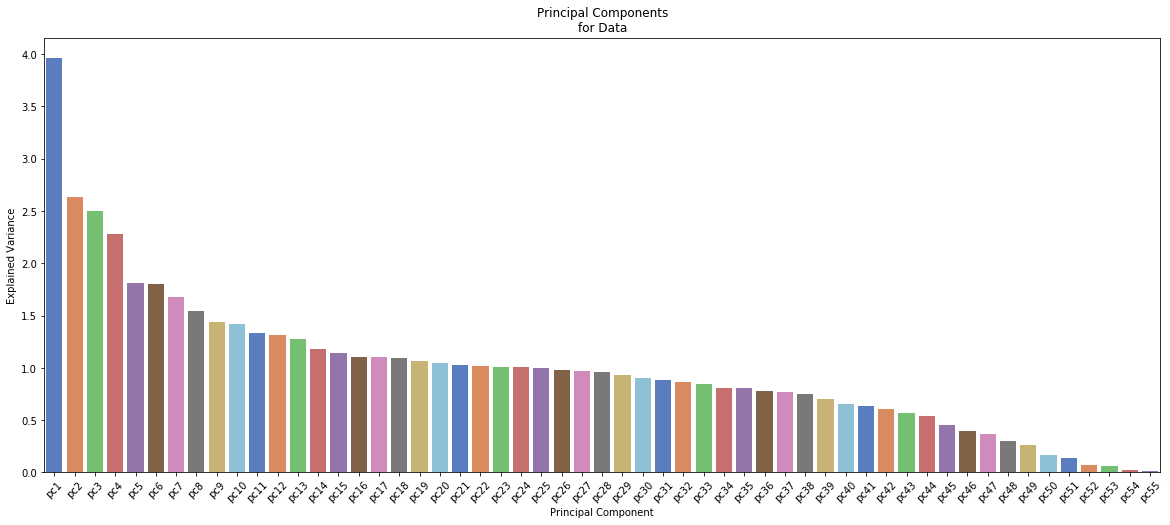

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex = True)
labels = ['pc' + str(i+1) for i in range(len(colnames))]
ax = sns.barplot(labels, pca.explained_variance_, palette='muted')
_ = plt.setp(ax.get_xticklabels(), rotation=45)
_ = plt.title('Principal Components\nfor Data')
_ = plt.xlabel('Principal Component')
_ = plt.ylabel('Explained Variance')

The first leveling off point is after 13 components. We'll try re-running the best model with 13 components.

In [53]:
pca = PCA(n_components=13)

# fit on sample data
pca.fit(X_train)

# can use to transform sample data or test/unseen data
Xpca_train = pca.transform(X_train)
Xpca_test = pca.transform(X_test)

We will run the reduced data on the next-best performing classifier, the tuned RandomForest model, to determine if we see any improvement, before trying it on the long-running XGBoost model. Tuning the RandomForest model took 1 hour for GridSearch, 3 hours for RandomSearch, and 9 minutes with default parameters.

In [54]:
# using best parameters determined from hyperparameter tuning and cross validation:
# [('bootstrap', True), ('max_features', 'sqrt'), ('n_estimators', 800)]
rfc = RandomForestClassifier(bootstrap=True, max_features='sqrt', n_estimators=800, random_state=42)
rfc_model, df_results = create_model('Random Forest PCA', rfc, dataset_type, Xpca_train, Xpca_test, y_train, y_test, tuning_model='None')
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5478  784  232]
 [ 993 3448  107]
 [ 426  130  282]]
Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.84      0.82      6494
           1       0.79      0.76      0.77      4548
           2       0.45      0.34      0.39       838

    accuracy                           0.78     11880
   macro avg       0.68      0.65      0.66     11880
weighted avg       0.77      0.78      0.77     11880

Run time:  0:02:40.653694


This model ran quickly but the results are not as good as the model produced before, where the F1 scores of class 0, 1 and 2 were 84, 80 and 39 respectively.  This could be because the cutoff of principal components was too aggressive.  We'll run the model again, this time using 38 components.

In [55]:
pca = PCA(n_components=38)

# fit on sample data
pca.fit(X_train)

# can use to transform sample data or test/unseen data
Xpca_train_38 = pca.transform(X_train)
Xpca_test_38 = pca.transform(X_test)
rfc = RandomForestClassifier(bootstrap=True, max_features='sqrt', n_estimators=800, random_state=42)
rfc_model, df_results = create_model('Random Forest PCA', rfc, dataset_type, Xpca_train_38, Xpca_test_38, y_train, y_test, tuning_model='None')
df_results.to_csv(results_file, mode='a', header=False)
df_all_results = pd.concat([df_all_results, df_results])

Confusion maxtrix: 
 [[5461  803  230]
 [ 963 3472  113]
 [ 435  130  273]]
Classification report: 
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      6494
           1       0.79      0.76      0.78      4548
           2       0.44      0.33      0.38       838

    accuracy                           0.77     11880
   macro avg       0.68      0.64      0.66     11880
weighted avg       0.77      0.77      0.77     11880

Run time:  0:05:20.895886


Interestingly, increasing the number of components did not improve the results. In fact, they were worse. The F1 scores with more components were not as good as the scores with fewer components.

Since performing dimension reduction with feature extraction via PCA did not improve the results on the next-best model, we will not attempt it on the top-performing model, XGBoost. Given the impractical duration of tuning that model further, we will leave that for future improvements.